In [1]:
import tensorflow as tf
import os
import numpy as np
import glob
import random
import cv2
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, BatchNormalization,Conv2DTranspose, concatenate,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
from keras import backend as K


In [2]:
data_folder = r"C:\Users\Desktop\veri"

In [3]:
train_folder = os.path.join(data_folder, "train")
test_folder = os.path.join(data_folder, "test")
validation_folder = os.path.join(data_folder, "validation")

In [4]:
#####Train
train_data = []
train_mask = []

for patient_folder in glob.glob(os.path.join(train_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        train_data.append(image)
        train_mask.append(mask)

# Veri --> numpy
train_data = np.array(train_data, dtype=object)
train_mask = np.array(train_mask, dtype=object)

#####Test
test_data = []
test_mask = []

for patient_folder in glob.glob(os.path.join(test_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    # image ve mask dosyalarını sırayla eşleştir
    for image_path, mask_path in zip(glob.glob(os.path.join(image_folder, "*.png")),
                                     glob.glob(os.path.join(mask_folder, "*.png"))):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        test_data.append(image)
        test_mask.append(mask)

# Veri --> numpy
test_data = np.array(test_data, dtype=object)
test_mask = np.array(test_mask, dtype=object)

#####Validation
validation_data = []
validation_mask = []

for patient_folder in glob.glob(os.path.join(validation_folder, "patient")):
    image_folder = os.path.join(patient_folder, "image")
    mask_folder = os.path.join(patient_folder, "mask")

    for image_path in glob.glob(os.path.join(image_folder, "*.png")):
        image = cv2.imread(image_path)
        validation_data.append(image)

    for mask_path in glob.glob(os.path.join(mask_folder, "*.png")):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        validation_mask.append(mask)

# Veri --> numpy
validation_data = np.array(validation_data, dtype=object)
validation_mask = np.array(validation_mask, dtype=object)


print("Eğitim verilerinin boyutu:", train_data.shape)
print("Eğitim maskelerinin boyutu:", train_mask.shape)
print("Test verilerinin boyutu:", test_data.shape)
print("Test maskelerinin boyutu:", test_data.shape)
print("validation verilerinin boyutu:", validation_data.shape)
print("validation maskelerinin boyutu:", validation_mask.shape)

Eğitim verilerinin boyutu: (1944,)
Eğitim maskelerinin boyutu: (1944,)
Test verilerinin boyutu: (282,)
Test maskelerinin boyutu: (282,)
validation verilerinin boyutu: (283,)
validation maskelerinin boyutu: (283,)


In [5]:
new_width = 128
new_height = 128

#Train

resized_train_data = []
for image in train_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_train_data.append(normalized_image)

resized_train_data = np.array(resized_train_data)

resized_train_mask = []
for mask in train_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    resized_mask = resized_mask/255.0
    resized_train_mask.append(resized_mask)
resized_train_mask = np.array(resized_train_mask)

resized_train_mask = resized_train_mask.reshape(-1, 128, 128, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu:", resized_train_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu:", resized_train_mask.shape)

#Test

resized_test_data = []

for image in test_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_test_data.append(normalized_image)

resized_test_data = np.array(resized_test_data)

resized_test_mask = []

for mask in test_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    resized_mask = resized_mask / 255.0
    resized_test_mask.append(resized_mask)

resized_test_mask = np.array(resized_test_mask)
resized_test_mask = resized_test_mask.reshape(-1, new_width, new_height, 1)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu:", resized_test_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu:", resized_test_mask.shape)

#Validation

resized_validation_data = []
for image in validation_data:
    resized_image = cv2.resize(image, (new_width, new_height))
    normalized_image = resized_image / 255.0  # 0-255 arası piksel değerlerini 0-1 arasına dönüştür
    resized_validation_data.append(normalized_image)

resized_validation_data = np.array(resized_validation_data)

resized_validation_mask = []
for mask in validation_mask:
    resized_mask = cv2.resize(mask, (new_width, new_height))
    normalized_mask = resized_mask / 255.0
    resized_validation_mask.append(normalized_mask)
resized_validation_mask = np.array(resized_validation_mask)
resized_validation_mask = resized_validation_mask.reshape(-1, new_width, new_height, 1)

print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu:", resized_validation_data.shape)
print("Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu:", resized_validation_mask.shape)


Yeniden boyutlandırılmış ve normalleştirilmiş eğitim verilerinin boyutu: (1944, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş eğitim maske verilerinin boyutu: (1944, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş test verilerinin boyutu: (282, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş test maske verilerinin boyutu: (282, 128, 128, 1)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  verilerinin boyutu: (283, 128, 128, 3)
Yeniden boyutlandırılmış ve normalleştirilmiş validation  maske verilerinin boyutu: (283, 128, 128, 1)


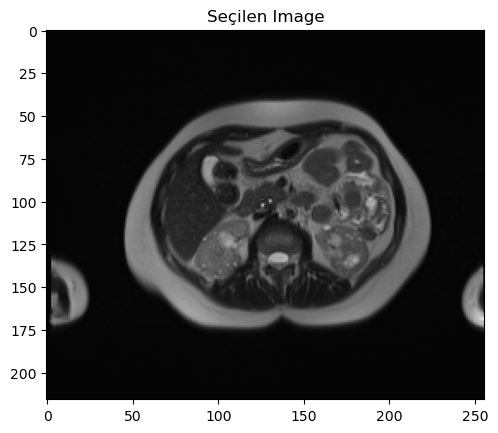

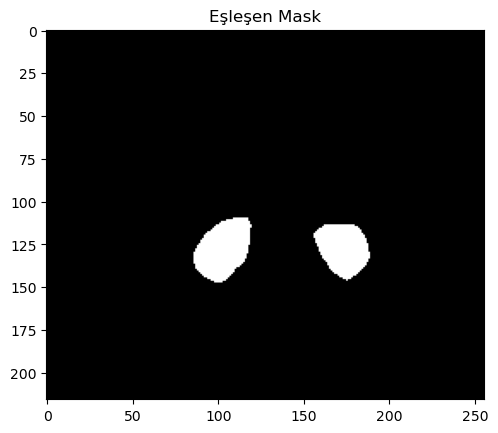

In [6]:
# Rastgele bir hastayı ve image/mask çiftini seçme
random_patient_folder = random.choice(glob.glob(os.path.join(train_folder, "patient")))
image_folder = os.path.join(random_patient_folder, "image")
mask_folder = os.path.join(random_patient_folder, "mask")

# image ve mask dosyalarını listeleme
image_files = glob.glob(os.path.join(image_folder, "*.png"))
mask_files = glob.glob(os.path.join(mask_folder, "*.png"))

# Rastgele bir image seçme
random_image_path = random.choice(image_files)
random_image = cv2.imread(random_image_path)

# Seçilen image ile hangi mask dosyasının eşleştiğini bulma
image_name = os.path.basename(random_image_path)
image_id = os.path.splitext(image_name)[0]
matching_mask_path = os.path.join(mask_folder, f"{image_id}.png")

# Eşleşen mask dosyasını yükleme
matching_mask = cv2.imread(matching_mask_path, cv2.IMREAD_GRAYSCALE)

# Seçilen Image'i görüntüleme
plt.imshow(random_image)
plt.title("Seçilen Image")
plt.show()

# Eşleşen mask'ı uygun bir NumPy dizisine dönüştürme
matching_mask = np.array(matching_mask, dtype=np.uint8)

plt.imshow(matching_mask, cmap='gray')
plt.title("Eşleşen Mask")
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma parametrelerini belirle
datagen = ImageDataGenerator(
    rotation_range=20,      # Rastgele döndürme (0 ile belirtilen derece arasında)
    width_shift_range=0.2,  # Genişlik yönlü kayma
    height_shift_range=0.2, # Yükseklik yönlü kayma
    shear_range=0.2,        # Kesme etkisi
    zoom_range=0.2,         # Rastgele yakınlaştırma
    horizontal_flip=True,   # Yatay çevirme
    vertical_flip=True,     # Dikey çevirme
    fill_mode='nearest',     # Eksik pikselleri doldurma yöntemi  
)

# Eğitim verisi ve maskeleri için veri artırma uygula
augmented_train_data = []
augmented_train_mask = []

for i in range(len(resized_train_data)):
    img = resized_train_data[i]
    mask = resized_train_mask[i]

    img = img.reshape((1,) + img.shape)  # Veri artırma işlemi genellikle batch olarak yapılır
    mask = mask.reshape((1,) + mask.shape)

    seed = np.random.randint(1, 1000)
    img_gen = datagen.flow(img, batch_size=1, seed=seed)
    mask_gen = datagen.flow(mask, batch_size=1, seed=seed)

    augmented_train_data.append(img_gen[0][0])
    augmented_train_mask.append(mask_gen[0][0])

augmented_train_data = np.array(augmented_train_data)
augmented_train_mask = np.array(augmented_train_mask)

# Veri artırma sonrası boyutları kontrol et
print("Veri artırma sonrası eğitim verilerinin boyutu:", augmented_train_data.shape)
print("Veri artırma sonrası eğitim maskelerinin boyutu:", augmented_train_mask.shape)


Veri artırma sonrası eğitim verilerinin boyutu: (1944, 128, 128, 3)
Veri artırma sonrası eğitim maskelerinin boyutu: (1944, 128, 128, 1)


In [7]:
# Orijinal ve artırılmış verileri birleştirme
combined_train_data = np.concatenate((resized_train_data, augmented_train_data), axis=0)
combined_train_mask = np.concatenate((resized_train_mask, augmented_train_mask), axis=0)

# Veri birleştirme sonrası boyutları kontrol et
print("Birleştirilmiş eğitim verilerinin boyutu:", combined_train_data.shape)
print("Birleştirilmiş eğitim maskelerinin boyutu:", combined_train_mask.shape)

Birleştirilmiş eğitim verilerinin boyutu: (3888, 128, 128, 3)
Birleştirilmiş eğitim maskelerinin boyutu: (3888, 128, 128, 1)


In [8]:
img_height = 128
img_width = 128
img_channel = 3

In [9]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [10]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


In [11]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [12]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn


In [13]:
def Attention_UNet(input_shape = (128,128,3), NUM_CLASSES=1, dropout_rate=0.2, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    attention_unet_model = tf.keras.Model(inputs, conv_final, name="Attention_UNet")
    return attention_unet_model


In [14]:
input_shape = (128, 128, 3)
attention_unet_model = Attention_UNet(input_shape=input_shape, NUM_CLASSES=1, dropout_rate=0.2, batch_norm=True)
attention_unet_model.summary()


Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

 conv2d_8 (Conv2D)              (None, 8, 8, 1024)   4719616     ['max_pooling2d_3[0][0]']        
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 1024)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 1024)   9438208     ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_9[0][0]']               
 rmalizati

 spose)                                                                                           
                                                                                                  
 conv2d_18 (Conv2D)             (None, 16, 16, 256)  262400      ['dropout_2[0][0]']              
                                                                                                  
 add_1 (Add)                    (None, 16, 16, 256)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'conv2d_18[0][0]']              
                                                                                                  
 activation_16 (Activation)     (None, 16, 16, 256)  0           ['add_1[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 16, 16, 1)    257         ['activation_16[0][0]']          
          

 concatenate_2 (Concatenate)    (None, 64, 64, 384)  0           ['up_sampling2d_5[0][0]',        
                                                                  'batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 64, 64, 128)  442496      ['concatenate_2[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 64, 64, 128)  512        ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_23 (Activation)     (None, 64, 64, 128)  0           ['batch_normalization_20[0][0]'] 
                                                                                                  
 conv2d_30

 conv2d_38 (Conv2D)             (None, 128, 128, 1)  65          ['dropout_8[0][0]']              
                                                                                                  
 batch_normalization_26 (BatchN  (None, 128, 128, 1)  4          ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_30 (Activation)     (None, 128, 128, 1)  0           ['batch_normalization_26[0][0]'] 
                                                                                                  
Total params: 37,334,665
Trainable params: 37,319,047
Non-trainable params: 15,618
__________________________________________________________________________________________________


In [15]:
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def F1(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=(1, 2))  # 128x128 piksel boyutunda toplama yap
    precision = (intersection + smooth) / (K.sum(y_pred, axis=(1, 2)) + smooth)
    recall = (intersection + smooth) / (K.sum(y_true, axis=(1, 2)) + smooth)
    f1 = 2 * (precision * recall) / (precision + recall)
    return K.mean(f1)

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def dice_coef(y_true, y_pred, smooth = 0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth))


# Grid Search

In [15]:
from sklearn.model_selection import ParameterGrid

In [16]:
# Define the hyperparameters grid
param_grid = {
    'learning_rate': [1e-3, 5e-3, 1e-4],
    'batch_size': [64],
    'epochs': [80]
}
# Convert the grid to a list of dictionaries
param_combinations = list(ParameterGrid(param_grid))


In [17]:
def build_compile_attention_unet(input_shape, learning_rate):
    attention_unet_model = Attention_UNet(input_shape)
    attention_unet_model.compile(
        optimizer=Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', F1, recall, precision, dice_coef, iou]
    )
    return attention_unet_model 

In [18]:
best_model = None
best_dice_coefficient = 0
input_shape = (img_height, img_width, img_channel)

In [19]:
for params in param_combinations:
    print(f"\nTraining with hyperparameters: {params}")

    # Build and compile model
    attention_unet_model = build_compile_attention_unet(input_shape, params['learning_rate'])

    # Train the model
    history = attention_unet_model.fit(
        resized_train_data,
        resized_train_mask,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(resized_validation_data, resized_validation_mask),
        verbose=2
    )
    
    # Evaluate the model on validation data
    eval_metrics = attention_unet_model.evaluate(resized_validation_data, resized_validation_mask, verbose=0)

    # Assuming 'dice_coef' is the metric at index 5
    dice_coefficient = eval_metrics[5]
    print(f"Validation dice coefficient: {dice_coefficient}")

    if dice_coefficient > best_dice_coefficient:
        best_dice_coefficient = dice_coefficient
        best_model = attention_unet_model

print("\nBest Hyperparameters:")
print(best_model.get_config())


Training with hyperparameters: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.001}
Epoch 1/40
54/54 - 1105s - loss: 0.5926 - accuracy: 0.9296 - F1: 0.1672 - recall: 0.9162 - precision: 0.5312 - dice_coef: 0.1747 - iou: 0.0942 - val_loss: 64.7296 - val_accuracy: 0.2092 - val_F1: 0.0321 - val_recall: 1.0000 - val_precision: 0.0180 - val_dice_coef: 0.0323 - val_iou: 0.0165 - 1105s/epoch - 20s/step
Epoch 2/40
54/54 - 1072s - loss: 0.5422 - accuracy: 0.9727 - F1: 0.1809 - recall: 0.9582 - precision: 0.6723 - dice_coef: 0.1902 - iou: 0.1028 - val_loss: 1.2272 - val_accuracy: 0.6339 - val_F1: 0.0405 - val_recall: 0.9192 - val_precision: 0.0346 - val_dice_coef: 0.0410 - val_iou: 0.0210 - 1072s/epoch - 20s/step
Epoch 3/40
54/54 - 1075s - loss: 0.5144 - accuracy: 0.9778 - F1: 0.1874 - recall: 0.9553 - precision: 0.7208 - dice_coef: 0.1976 - iou: 0.1071 - val_loss: 0.5234 - val_accuracy: 0.9844 - val_F1: 0.0281 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_dice_coef: 0.0285 - v

Epoch 27/40
54/54 - 1077s - loss: 0.1790 - accuracy: 0.9935 - F1: 0.3523 - recall: 0.9588 - precision: 0.9357 - dice_coef: 0.3851 - iou: 0.2244 - val_loss: 0.1955 - val_accuracy: 0.9919 - val_F1: 0.1031 - val_recall: 0.6981 - val_precision: 0.7706 - val_dice_coef: 0.1109 - val_iou: 0.0568 - 1077s/epoch - 20s/step
Epoch 28/40
54/54 - 1072s - loss: 0.1721 - accuracy: 0.9937 - F1: 0.3595 - recall: 0.9593 - precision: 0.9396 - dice_coef: 0.3938 - iou: 0.2301 - val_loss: 0.1924 - val_accuracy: 0.9915 - val_F1: 0.1066 - val_recall: 0.7041 - val_precision: 0.7502 - val_dice_coef: 0.1150 - val_iou: 0.0589 - 1072s/epoch - 20s/step
Epoch 29/40
54/54 - 1079s - loss: 0.1662 - accuracy: 0.9937 - F1: 0.3665 - recall: 0.9589 - precision: 0.9396 - dice_coef: 0.4015 - iou: 0.2355 - val_loss: 0.1905 - val_accuracy: 0.9907 - val_F1: 0.1238 - val_recall: 0.8420 - val_precision: 0.6531 - val_dice_coef: 0.1335 - val_iou: 0.0690 - 1079s/epoch - 20s/step
Epoch 30/40
54/54 - 1073s - loss: 0.1603 - accuracy: 0.

Epoch 13/40
54/54 - 1086s - loss: 0.0839 - accuracy: 0.9893 - F1: 0.5010 - recall: 0.9043 - precision: 0.9088 - dice_coef: 0.5641 - iou: 0.3544 - val_loss: 0.0924 - val_accuracy: 0.9888 - val_F1: 0.1614 - val_recall: 0.5502 - val_precision: 0.6350 - val_dice_coef: 0.1814 - val_iou: 0.0936 - 1086s/epoch - 20s/step
Epoch 14/40
54/54 - 1081s - loss: 0.0794 - accuracy: 0.9887 - F1: 0.5149 - recall: 0.8975 - precision: 0.9055 - dice_coef: 0.5785 - iou: 0.3673 - val_loss: 0.0880 - val_accuracy: 0.9892 - val_F1: 0.1810 - val_recall: 0.5935 - val_precision: 0.6575 - val_dice_coef: 0.2034 - val_iou: 0.1061 - 1081s/epoch - 20s/step
Epoch 15/40
54/54 - 1080s - loss: 0.0715 - accuracy: 0.9896 - F1: 0.5394 - recall: 0.9040 - precision: 0.9157 - dice_coef: 0.6056 - iou: 0.3910 - val_loss: 0.1301 - val_accuracy: 0.9817 - val_F1: 0.2287 - val_recall: 0.8486 - val_precision: 0.4320 - val_dice_coef: 0.2535 - val_iou: 0.1379 - 1080s/epoch - 20s/step
Epoch 16/40
54/54 - 1081s - loss: 0.0643 - accuracy: 0.

54/54 - 1080s - loss: 0.0212 - accuracy: 0.9937 - F1: 0.7958 - recall: 0.9444 - precision: 0.9532 - dice_coef: 0.8549 - iou: 0.6816 - val_loss: 0.0403 - val_accuracy: 0.9914 - val_F1: 0.4531 - val_recall: 0.7808 - val_precision: 0.6845 - val_dice_coef: 0.5316 - val_iou: 0.3213 - 1080s/epoch - 20s/step
Epoch 40/40
54/54 - 1089s - loss: 0.0205 - accuracy: 0.9938 - F1: 0.8016 - recall: 0.9446 - precision: 0.9546 - dice_coef: 0.8598 - iou: 0.6892 - val_loss: 0.0373 - val_accuracy: 0.9916 - val_F1: 0.4079 - val_recall: 0.6369 - val_precision: 0.7767 - val_dice_coef: 0.4839 - val_iou: 0.2844 - 1089s/epoch - 20s/step
Validation dice coefficient: 0.4839012026786804

Training with hyperparameters: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.0001}
Epoch 1/40
54/54 - 1092s - loss: 0.6020 - accuracy: 0.9027 - F1: 0.1658 - recall: 0.9318 - precision: 0.4585 - dice_coef: 0.1733 - iou: 0.0933 - val_loss: 0.6491 - val_accuracy: 0.9837 - val_F1: 0.0285 - val_recall: 0.0378 - val_precision: 0.36

Epoch 25/40
54/54 - 1163s - loss: 0.4971 - accuracy: 0.9914 - F1: 0.1975 - recall: 0.9813 - precision: 0.8777 - dice_coef: 0.2080 - iou: 0.1134 - val_loss: 0.5245 - val_accuracy: 0.9882 - val_F1: 0.0558 - val_recall: 0.8368 - val_precision: 0.5740 - val_dice_coef: 0.0574 - val_iou: 0.0293 - 1163s/epoch - 22s/step
Epoch 26/40
54/54 - 1091s - loss: 0.4947 - accuracy: 0.9913 - F1: 0.1980 - recall: 0.9809 - precision: 0.8779 - dice_coef: 0.2087 - iou: 0.1137 - val_loss: 0.5352 - val_accuracy: 0.9810 - val_F1: 0.0591 - val_recall: 0.9133 - val_precision: 0.4241 - val_dice_coef: 0.0609 - val_iou: 0.0312 - 1091s/epoch - 20s/step
Epoch 27/40
54/54 - 1216s - loss: 0.4919 - accuracy: 0.9917 - F1: 0.1987 - recall: 0.9807 - precision: 0.8840 - dice_coef: 0.2095 - iou: 0.1142 - val_loss: 0.5365 - val_accuracy: 0.9810 - val_F1: 0.0598 - val_recall: 0.9150 - val_precision: 0.4239 - val_dice_coef: 0.0616 - val_iou: 0.0315 - 1216s/epoch - 23s/step
Epoch 28/40
54/54 - 1248s - loss: 0.4896 - accuracy: 0.

AbortedError: Graph execution error:

Detected at node 'Attention_UNet/conv2d_126/BiasAdd' defined at (most recent call last):
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 2974, in run_cell
      result = self._run_cell(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3256, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\IPython\core\interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\BUKET\AppData\Local\Temp\ipykernel_8444\3936699943.py", line 8, in <cell line: 1>
      history = attention_unet_model.fit(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1445, in fit
      val_logs = self.evaluate(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 1499, in test_step
      y_pred = self(x, training=False)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\BUKET\anaconda3\envs\DeepLearning\lib\site-packages\keras\layers\convolutional\base_conv.py", line 269, in call
      outputs = tf.nn.bias_add(
Node: 'Attention_UNet/conv2d_126/BiasAdd'
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_ops.cc:930
	 [[{{node Attention_UNet/conv2d_126/BiasAdd}}]] [Op:__inference_test_function_93556]

In [16]:
from sklearn.model_selection import KFold

# K-Fold Cross Validation için KFold nesnesini oluşturun
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_loss, all_val_loss, all_train_acc, all_val_acc = [], [], [], []

fold = 0

for train_index, test_index in kf.split(resized_train_data, resized_train_mask):
    fold += 1
    print(f"Fold {fold}:")

    # Eğitim ve test setlerini oluşturun
    X_train_fold, X_test_fold = resized_train_data[train_index], resized_train_data[test_index]
    y_train_fold, y_test_fold = resized_train_mask[train_index], resized_train_mask[test_index]

    # Yeni bir model oluşturun (her fold için yeni bir model)
    attention_unet_model = Attention_UNet((img_height, img_width, 3))

    # Modeli derle
    attention_unet_model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', F1, recall, precision, dice_coef, iou])

    # Modeli eğitin
    history = attention_unet_model.fit(X_train_fold, 
                              y_train_fold, 
                              epochs=10, 
                              batch_size=32, 
                              verbose=1)

    # Modeli test edin
    test_results = attention_unet_model.evaluate(X_test_fold, y_test_fold, batch_size=32)

    # Eğitim ve validation loss/accuracy değerlerini kaydedin
    all_train_loss.append(history.history['loss'])
    all_train_acc.append(history.history['accuracy'])
    all_val_loss.append(test_results[0])  # test_results içinde loss değeri 0. indexte
    all_val_acc.append(test_results[1])   # test_results içinde accuracy değeri 1. indexte


Fold 1:
Epoch 1/10
43/43 [==============================] - 803s 18s/step - loss: 0.5987 - accuracy: 0.9282 - F1: 0.1616 - recall: 0.9039 - precision: 0.5010 - dice_coef: 0.1690 - iou: 0.0907
Epoch 2/10
43/43 [==============================] - 782s 18s/step - loss: 0.5534 - accuracy: 0.9695 - F1: 0.1763 - recall: 0.9512 - precision: 0.6437 - dice_coef: 0.1851 - iou: 0.0999
Epoch 3/10
43/43 [==============================] - 794s 18s/step - loss: 0.5296 - accuracy: 0.9746 - F1: 0.1825 - recall: 0.9548 - precision: 0.6881 - dice_coef: 0.1920 - iou: 0.1038
Epoch 4/10
43/43 [==============================] - 783s 18s/step - loss: 0.5080 - accuracy: 0.9784 - F1: 0.1873 - recall: 0.9536 - precision: 0.7266 - dice_coef: 0.1975 - iou: 0.1070
Epoch 5/10
43/43 [==============================] - 786s 18s/step - loss: 0.4876 - accuracy: 0.9808 - F1: 0.1925 - recall: 0.9544 - precision: 0.7525 - dice_coef: 0.2033 - iou: 0.1103
Epoch 6/10
43/43 [==============================] - 784s 18s/step - loss

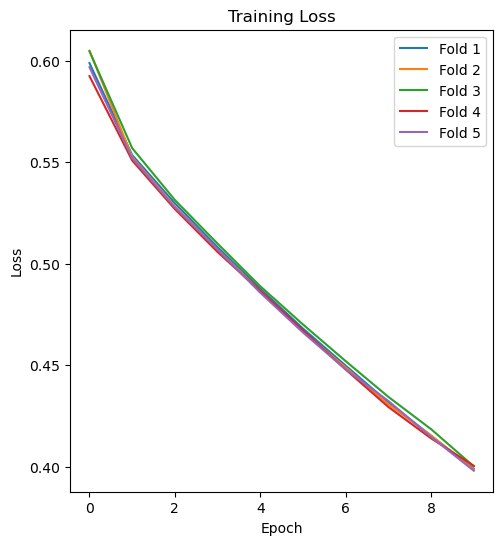

In [17]:
# Eğitim ve validation loss grafiği çizin
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(5):
    plt.plot(all_train_loss[i], label=f'Fold {i + 1}')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [14]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.LearningRateScheduler(scheduler)]

In [15]:
specified_learning_rate = 5e-3

attention_unet_model.compile(
    optimizer=Adam(learning_rate=specified_learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', F1, recall, precision, dice_coef, iou]
)

In [16]:
#Grid--> 0.005 learning_rate, 16 batch; 40 epochs;
test_results = attention_unet_model.fit(
    resized_train_data, 
    resized_train_mask, 
    batch_size=16, 
    epochs=40, 
    validation_data=(resized_validation_data, resized_validation_mask),
    callbacks=callbacks
)

Epoch 1/40
108/108 [==============================] - 1454s 13s/step - loss: 0.5723 - accuracy: 0.9472 - F1: 0.1714 - recall: 0.9257 - precision: 0.5651 - dice_coef: 0.1791 - iou: 0.0968 - val_loss: 4.8337 - val_accuracy: 0.3050 - val_F1: 0.0367 - val_recall: 0.9998 - val_precision: 0.0209 - val_dice_coef: 0.0370 - val_iou: 0.0190 - lr: 0.0010
Epoch 2/40
108/108 [==============================] - 1111s 10s/step - loss: 0.5076 - accuracy: 0.9747 - F1: 0.1881 - recall: 0.9461 - precision: 0.6930 - dice_coef: 0.1978 - iou: 0.1074 - val_loss: 0.5226 - val_accuracy: 0.9707 - val_F1: 0.0446 - val_recall: 0.5575 - val_precision: 0.2870 - val_dice_coef: 0.0459 - val_iou: 0.0233 - lr: 0.0010
Epoch 3/40
108/108 [==============================] - 1101s 10s/step - loss: 0.4597 - accuracy: 0.9797 - F1: 0.2002 - recall: 0.9463 - precision: 0.7452 - dice_coef: 0.2114 - iou: 0.1153 - val_loss: 0.4939 - val_accuracy: 0.9598 - val_F1: 0.0470 - val_recall: 0.6923 - val_precision: 0.2244 - val_dice_coef: 

Epoch 25/40
108/108 [==============================] - 1305s 12s/step - loss: 0.0884 - accuracy: 0.9935 - F1: 0.4968 - recall: 0.9476 - precision: 0.9467 - dice_coef: 0.5498 - iou: 0.3485 - val_loss: 0.0985 - val_accuracy: 0.9928 - val_F1: 0.1798 - val_recall: 0.7255 - val_precision: 0.8173 - val_dice_coef: 0.2028 - val_iou: 0.1056 - lr: 0.0010
Epoch 26/40
108/108 [==============================] - 1315s 12s/step - loss: 0.0834 - accuracy: 0.9936 - F1: 0.5088 - recall: 0.9481 - precision: 0.9483 - dice_coef: 0.5635 - iou: 0.3598 - val_loss: 0.0923 - val_accuracy: 0.9918 - val_F1: 0.1570 - val_recall: 0.5896 - val_precision: 0.8732 - val_dice_coef: 0.1810 - val_iou: 0.0921 - lr: 0.0010
Epoch 27/40
108/108 [==============================] - 1193s 11s/step - loss: 0.0788 - accuracy: 0.9937 - F1: 0.5217 - recall: 0.9487 - precision: 0.9497 - dice_coef: 0.5778 - iou: 0.3719 - val_loss: 0.0960 - val_accuracy: 0.9914 - val_F1: 0.2057 - val_recall: 0.7932 - val_precision: 0.7001 - val_dice_coe

In [17]:
# Modelin ağırlıklarını ve konfigürasyonunu kaydetme
attention_unet_model.save('attention_unet_model_16b_lr005_40epch.h5')

# Eğitim geçmişini kaydetme (pickle ile)
import pickle

with open('training_history_attention_unet_model_16b_lr005_40epch.pkl', 'wb') as history_file:
    pickle.dump(test_results.history, history_file)

In [25]:
loaded_half_unet_model = load_model("attention_unet_model_16b_lr005_40epch.h5", custom_objects={ 
                                                                                    'dice_coef': dice_coef,
                                                                                    'F1':F1, 
                                                                                    'recall':recall, 
                                                                                    'precision':precision,
                                                                                    'iou':iou})


In [26]:
predictions = loaded_half_unet_model.predict(resized_test_data)

9/9 [==============================] - 53s 6s/step


In [27]:
predictions = loaded_half_unet_model.predict(resized_test_data)
def binary_predictions(predictions, threshold=0.5):
    """
    Tahmin olasılıklarını binary değerlere çevirir.

    Argümanlar:
    - predictions: Model tahmin olasılıkları
    - threshold: Eşik değeri

    Returns:
    - binary_predictions: Belirlenen eşik değerine göre ikili tahminler
    """
    binary_predictions = (predictions > threshold).astype(np.uint8)
    return binary_predictions

predicted_mask_probabilities = loaded_half_unet_model.predict(resized_test_data)  # Modelin tahmin olasılıkları
binary_mask_predictions = binary_predictions(predicted_mask_probabilities, threshold=0.5)


9/9 [==============================] - 56s 6s/step


In [23]:
import pickle

# Eğitim geçmişini yükleyin
with open('training_history_attention_unet_model_16b_lr005_40epch.pkl', 'rb') as history_file:
    history = pickle.load(history_file)

In [24]:
#code for visualizing all the metrics and the loss during training
import matplotlib.pyplot as plt, random, numpy as np, cv2
from PIL import Image
from keras import backend as K

def training_history_plot(results):
        """Plots "training curve" for the network/model for metrics listed below:
                1. Dice loss
                2. Pixel-wise accuracy
                3. Intersection Over Union(IOU)
                4. F1 score
                5. Recall
                6. Precision
    Args:
        results (History): Output of 'model.fit_generator()', 'History.history' attribute is a record of metrics
                                values as described above(from 1-6)
    Returns:
        None
        """
        titles = ["dice_loss",'accuracy', "iou", "F1", "recall", "precision", "dice_coef"]
        metric = ['loss', 'accuracy', 'iou','F1','recall','precision','dice_coef'] # Metrics we're keeping track off
        val_metric = ['val_loss', 'val_accuracy', 'val_iou','val_F1','val_recall','val_precision','val_dice_coef']
        # Define specification of our plot
        fig, axs = plt.subplots(4,2, figsize=(15, 15), facecolor='w', edgecolor='k')
        fig.subplots_adjust(hspace = 0.5, wspace=0.2)
        axs = axs.ravel()

        for i in range(7):
            axs[i].plot(results.history[metric[i]]) # Calls from 'History.history'- 'metric[i]', note 'results' is
            axs[i].plot(results.history[val_metric[i]])
            axs[i].set_title(titles[i]) # a 'History' object
            axs[i].set_xlabel('epoch')
            axs[i].set_ylabel(metric[i])
            axs[i].legend(['train'], loc='upper left')

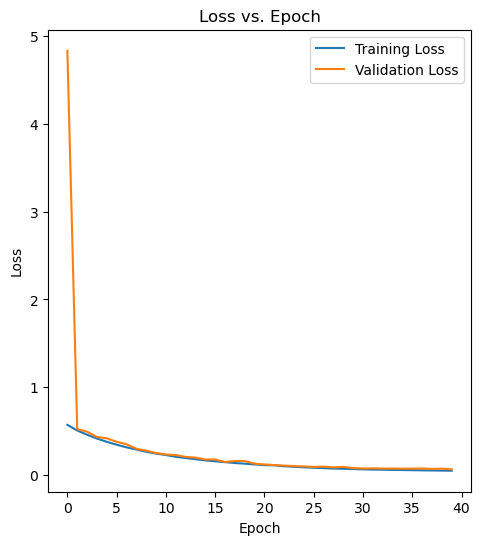

In [25]:
import matplotlib.pyplot as plt

# Eğitim geçmişini görselleştirme
# İki grafik için subplot oluşturun
plt.figure(figsize=(12, 6))

# Eğitim ve doğrulama kayıplarını ilk grafikte çizin
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epoch')

plt.show()
